In [1]:
import tensorflow as tf

# Check for GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Number of GPUs available: {len(gpus)}")
    for i, gpu in enumerate(gpus):
        print(f"GPU {i}: {gpu}")
else:
    print("No GPU found.")

# Check for TPUs
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Will throw an error if no TPU is available
    print(f"TPU detected: {tpu}")
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    print("TPU system initialized.")
except ValueError:
    print("No TPU found.")


Number of GPUs available: 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
No TPU found.


In [2]:
import numpy as np
import pandas as pd


In [4]:
import zipfile

# Path to the uploaded zip file
zip_path = '/content/sorted_data.zip'

# Extract to /content/training
extract_path = '/content/sorted_data'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Extracted to {extract_path}")

Extracted to /content/sorted_data


In [5]:
# List files in the extracted directory
!ls /content/sorted_data



content


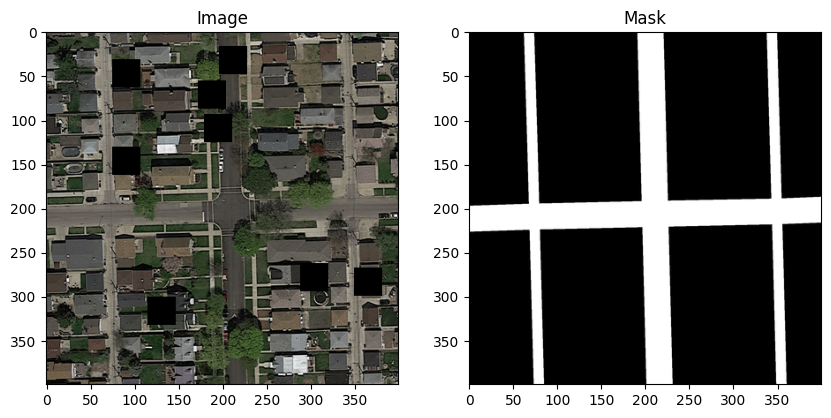

In [6]:
#for loading the images and groundtruth

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Path to the images and groundtruth directories
image_dir = '/content/sorted_data/content/sorted_images'
mask_dir = '/content/sorted_data/content/sorted_masks'

# List image files
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

# Function to load an image and its corresponding mask
def load_image_mask(image_file, mask_file):
    image_path = os.path.join(image_dir, image_file)
    mask_path = os.path.join(mask_dir, mask_file)

    # Read the image and the mask
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Assuming mask is grayscale

    return image, mask

# Load a sample image and mask
image, mask = load_image_mask(image_files[0], mask_files[0])

# Display the image and its corresponding mask
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')

plt.show()

In [7]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 62.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=bba7aab26fc3224099042288666c14c6ace428326a4dcc71e90cfc949229a00c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=b569801fb9b30b19d5cad7360fb0d68af37c503101e4133c39632449e264cd52
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (add, Activation, BatchNormalization, concatenate,
                                      Conv2D, Input, MaxPooling2D, UpSampling2D, ZeroPadding2D)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import cv2


In [9]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

# Paths
image_dir = '/content/sorted_data/content/sorted_images'
mask_dir = '/content/sorted_data/content/sorted_masks'

# Target size for resizing (256 x 256)
target_size = (256, 256)

# Function to resize and normalize images
def load_and_preprocess_images(image_files, image_dir, target_size):
    images = []
    for file in image_files:
        img = cv2.imread(os.path.join(image_dir, file), cv2.IMREAD_COLOR)
        img = cv2.resize(img, target_size)  # Resize to target size
        img = img / 255.0  # Normalize to [0, 1]
        images.append(img)
    return np.array(images, dtype=np.float32)

# Function to resize and normalize masks
def load_and_preprocess_masks(mask_files, mask_dir, target_size):
    masks = []
    for file in mask_files:
        mask = cv2.imread(os.path.join(mask_dir, file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, target_size)  # Resize to target size
        mask = mask / 255.0  # Normalize to [0, 1]
        masks.append(mask)
    return np.expand_dims(np.array(masks, dtype=np.float32), axis=-1)  # Add channel dimension

# Load and preprocess the data
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))
images = load_and_preprocess_images(image_files, image_dir, target_size)
masks = load_and_preprocess_masks(mask_files, mask_dir, target_size)

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Check shapes
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")


Training set: (560, 256, 256, 3), Validation set: (70, 256, 256, 3), Test set: (70, 256, 256, 3)


#Define the Segnet Model


In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def build_signet(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.3)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.4)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.3)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = build_signet()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 128)  │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 256)    │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 512)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

#Train Model

In [11]:
# ... (previous code to build the model: build_signet() and model.summary())

# Compile the Model before training:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Now you can train the model:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    verbose=1
)

# ... (rest of the code)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.6964 - loss: 0.5848 - val_accuracy: 0.7647 - val_loss: 0.4889
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 49s 822ms/step - accuracy: 0.7682 - loss: 0.4643 - val_accuracy: 0.7647 - val_loss: 0.4622
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 844ms/step - accuracy: 0.7683 - loss: 0.4490 - val_accuracy: 0.7647 - val_loss: 0.4491
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 831ms/step - accuracy: 0.7696 - loss: 0.4269 - val_accuracy: 0.6553 - val_loss: 0.4590
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 821ms/step - accuracy: 0.7635 - loss: 0.4509 - val_accuracy: 0.7647 - val_loss: 0.4673
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 813ms/step - accuracy: 0.7746 - loss: 0.4470 - val_accuracy: 0.7647 - val_loss: 0.4602
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 806ms/step - accuracy: 0.7669 - loss: 0.4473 - val_accuracy: 0.7647 - val_loss: 0.4556
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 838ms/step - accuracy: 0.7654 - loss: 0.4405 - val_accura

In [12]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 40s 294ms/step - accuracy: 0.7666 - loss: 0.1347
Test Loss: 0.135904923081398, Test Accuracy: 0.7670708894729614


#Optimization

In [14]:
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.layers import UpSampling2D, concatenate, Dropout, Lambda
from keras.models import Model
from keras.applications import ResNet50
from keras.optimizers import SGD
import tensorflow as tf

# Pyramid Pooling Module
def pyramid_pooling_module(input_tensor, pool_sizes=[1, 2, 4, 8]):
    pool_outs = []

    for pool_size in pool_sizes:
        # Pool to a smaller size
        pooled = tf.keras.layers.AveragePooling2D(pool_size, strides=pool_size, padding='same')(input_tensor)
        pooled = Conv2D(256, (1, 1), padding='same', activation='relu')(pooled)
        pooled = Dropout(0.3)(pooled)  # Added dropout here
        # Resize to match input tensor size using Lambda
        pooled = Lambda(lambda x: tf.image.resize(x, (input_tensor.shape[1], input_tensor.shape[2])))(pooled)
        pool_outs.append(pooled)

    # Concatenate pooled features with the original input tensor
    return concatenate(pool_outs + [input_tensor])

def modell(input_size=(128, 128, 3), num_classes=1):
    inputs = Input(input_size)

    # ResNet50 base without the top layers
    resnet_base = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)

    # Extract features from intermediate layers
    c1 = resnet_base.get_layer("conv1_relu").output  # First block
    c2 = resnet_base.get_layer("conv2_block3_out").output  # Second block
    c3 = resnet_base.get_layer("conv3_block4_out").output  # Third block
    c4 = resnet_base.get_layer("conv4_block6_out").output  # Fourth block

    # Pyramid Pooling Module on the last block
    ppm = pyramid_pooling_module(c4, pool_sizes=[1, 2, 4, 8])

    # Decoder: SegNet-like architecture
    u1 = UpSampling2D((2, 2))(ppm)
    u1 = concatenate([u1, c3])
    u1 = Conv2D(256, (3, 3), padding='same', activation='relu')(u1)
    u1 = Dropout(0.3)(u1)  # Added dropout

    u2 = UpSampling2D((2, 2))(u1)
    u2 = concatenate([u2, c2])
    u2 = Conv2D(128, (3, 3), padding='same', activation='relu')(u2)
    u2 = Dropout(0.3)(u2)  # Added dropout

    u3 = UpSampling2D((2, 2))(u2)
    u3 = concatenate([u3, c1])
    u3 = Conv2D(64, (3, 3), padding='same', activation='relu')(u3)
    u3 = Dropout(0.3)(u3)  # Added dropout

    # Deep Supervision (Intermediate Loss Layers)
    intermediate_output1 = Conv2D(num_classes, (1, 1), activation='sigmoid', name="output1")(u1)
    intermediate_output2 = Conv2D(num_classes, (1, 1), activation='sigmoid', name="output2")(u2)

    # Final Output
    final_output = Conv2D(num_classes, (1, 1), activation='sigmoid', name="final_output")(u3)

    # Make the model with multiple outputs
    model = Model(inputs=inputs, outputs=[final_output, intermediate_output1, intermediate_output2])

    # Compile model using SGD optimizer with learning rate decay
    model.compile(
        optimizer=SGD(learning_rate=0.01, momentum=0.9),  # Using SGD with momentum
        loss="binary_crossentropy",  # Binary cross-entropy loss for segmentation
        metrics=["accuracy"],
    )

    return model

# Instantiate the model
modell_model = modell(input_size=(128, 128, 3))

# Show model summary to understand the architecture
modell_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 16,238,339 (61.94 MB)

 Trainable params: 16,207,747 (61.83 MB)

 Non-trainable params: 30,592 (119.50 KB)



##Augmentation

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Fit generators on the data
image_datagen.fit(X_train)
mask_datagen.fit(y_train)

# Make augmented datasets
image_generator = image_datagen.flow(X_train, batch_size=16, seed=42)
mask_generator = mask_datagen.flow(y_train, batch_size=16, seed=42)

train_generator = zip(image_generator, mask_generator)


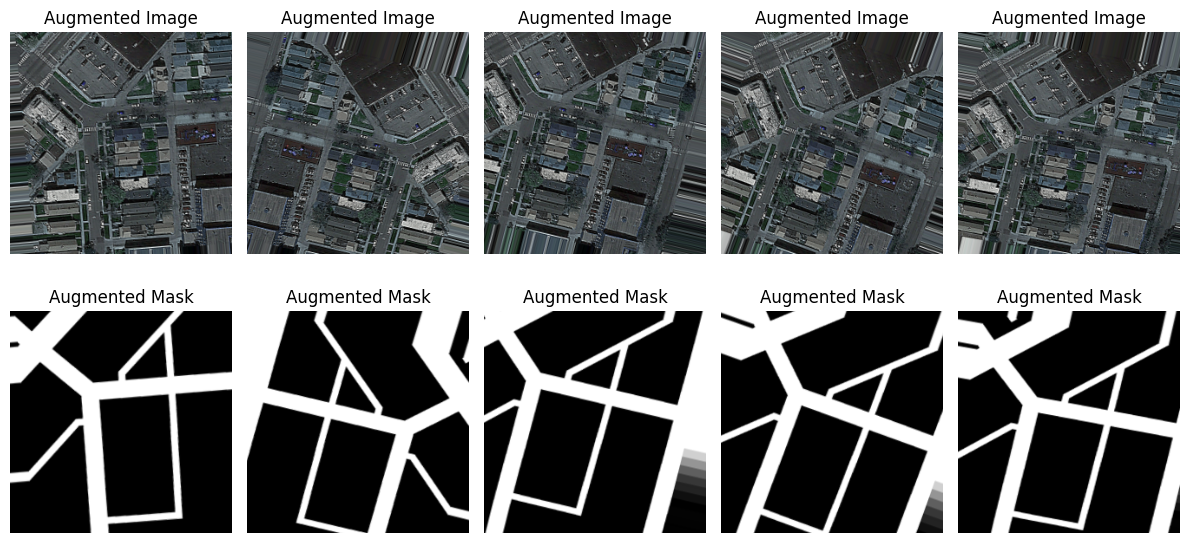

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define augmentation parameters
data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')

# Make ImageDataGenerator instances for images and masks
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Fit the generators
image_datagen.fit(X_train)
mask_datagen.fit(y_train)

# Select one sample for visualization
sample_image = X_train[0:1]  # Shape (1, height, width, channels)
sample_mask = y_train[0:1]  # Shape (1, height, width, 1)

# Generate augmented samples
image_generator = image_datagen.flow(sample_image, batch_size=1, seed=42)
mask_generator = mask_datagen.flow(sample_mask, batch_size=1, seed=42)

# Visualize the results
plt.figure(figsize=(12, 6))

for i in range(5):  # Display 5 augmented samples
    augmented_image = next(image_generator)[0]  # Get next augmented image
    augmented_mask = next(mask_generator)[0]  # Get next augmented mask

    # Display image
    plt.subplot(2, 5, i + 1)
    plt.imshow(augmented_image)
    plt.axis('off')
    plt.title('Augmented Image')

    # Display mask
    plt.subplot(2, 5, i + 6)
    plt.imshow(augmented_mask.squeeze(), cmap='gray')
    plt.axis('off')
    plt.title('Augmented Mask')

plt.tight_layout()
plt.show()


In [17]:
import numpy as np

def add_gaussian_noise(image, mean=0, std=0.1):
    """Add Gaussian noise to an image."""
    noise = np.random.normal(mean, std, image.shape)  # Generate Gaussian noise
    noisy_image = image + noise  # Add noise to the image
    noisy_image = np.clip(noisy_image, 0, 1)  # Ensure pixel values are in the valid range [0, 1]
    return noisy_image


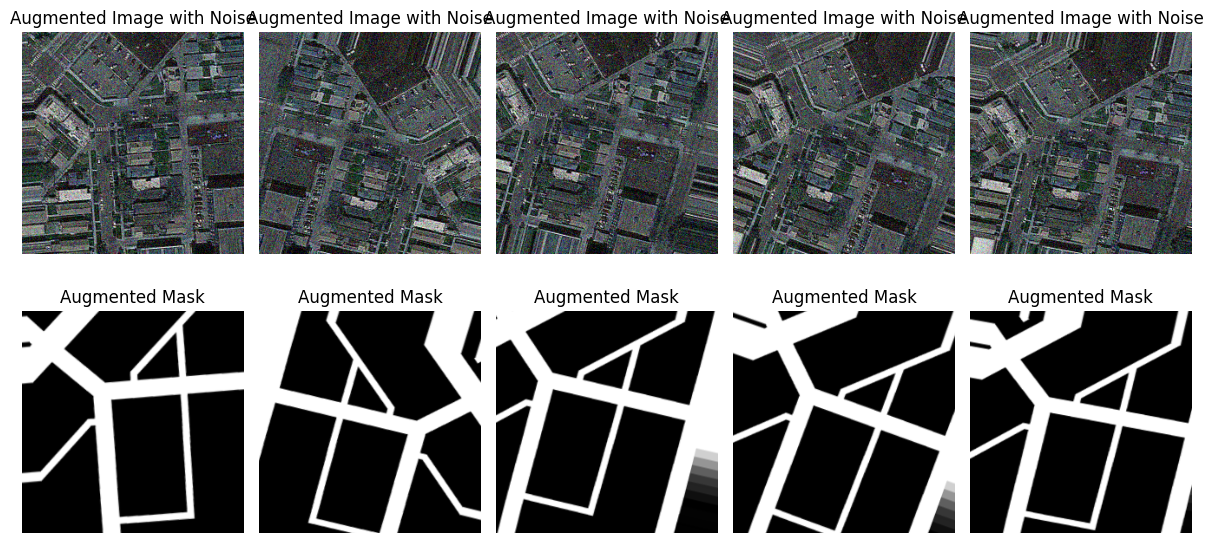

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define augmentation parameters
data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')

# ImageDataGenerator instances for images and masks
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Fit the generators
image_datagen.fit(X_train)
mask_datagen.fit(y_train)

# Select one sample for visualization
sample_image = X_train[0:1]  # Shape (1, height, width, channels)
sample_mask = y_train[0:1]  # Shape (1, height, width, 1)

# Generate augmented samples
image_generator = image_datagen.flow(sample_image, batch_size=1, seed=42)
mask_generator = mask_datagen.flow(sample_mask, batch_size=1, seed=42)

# Visualize the results with noise addition
plt.figure(figsize=(12, 6))

for i in range(5):  # Display 5 augmented samples with noise
    augmented_image = next(image_generator)[0]  # Get next augmented image
    augmented_mask = next(mask_generator)[0]  # Get next augmented mask

    # Add Gaussian noise to the augmented image
    noisy_image = add_gaussian_noise(augmented_image)

    # Display the original augmented image with noise
    plt.subplot(2, 5, i + 1)
    plt.imshow(noisy_image)
    plt.axis('off')
    plt.title('Augmented Image with Noise')

    # Display mask
    plt.subplot(2, 5, i + 6)
    plt.imshow(augmented_mask.squeeze(), cmap='gray')
    plt.axis('off')
    plt.title('Augmented Mask')

plt.tight_layout()
plt.show()


##F1 Score

In [19]:
from sklearn.metrics import f1_score
import numpy as np

# Initialize variables to store ground truths and predictions
all_ground_truths = []
all_predictions = []

# Iterate through your dataset
for idx in range(len(X_test)):
    # Load the image and mask
    image = X_test[idx]
    mask = y_test[idx]

    # Convert the ground truth mask to binary (0 or 1) and flatten
    mask_np = (mask > 0.5).astype(np.uint8).flatten()

    # Predict the mask
    predicted_mask = model.predict(np.expand_dims(image, axis=0))[0].squeeze()

    # Threshold the predicted mask to binary (0 or 1) and flatten
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8).flatten()

    # Append ground truth and predictions
    all_ground_truths.extend(mask_np)
    all_predictions.extend(predicted_mask)

# Calculate F1 Score
f1 = f1_score(all_ground_truths, all_predictions)
print(f"F1 Score for the dataset: {f1:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━

In [20]:
from sklearn.metrics import accuracy_score
import numpy as np

# Convert predictions to binary (0 or 1) for accuracy calculation
y_pred_binary = (model.predict(X_test) > 0.5).astype(np.uint8)  # Assuming sigmoid activation for binary output

# Ensure both ground truth and predictions are of the same type (float in this case)
y_test_flat = y_test.flatten().astype(np.uint8)  # Flatten and convert to uint8
y_pred_flat = y_pred_binary.flatten()  # Flatten the predicted mask

# Calculate accuracy
accuracy = accuracy_score(y_test_flat, y_pred_flat)

print(f"Accuracy: {accuracy:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 412ms/step
Accuracy: 0.8194


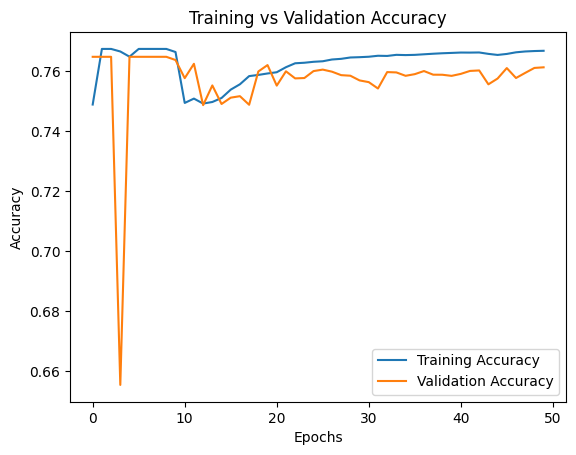

In [21]:
import matplotlib.pyplot as plt

# Assuming `history` is the training history returned by `model.fit`
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


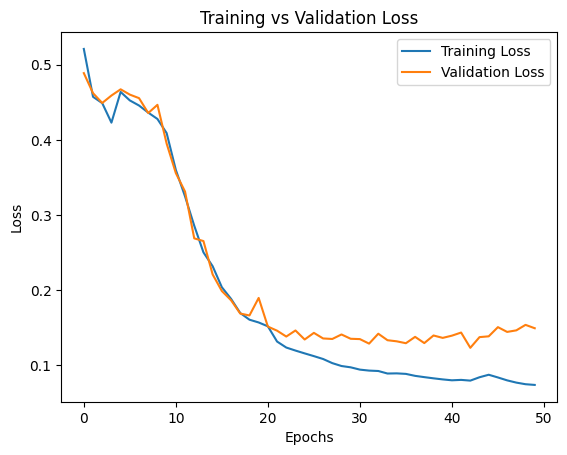

In [22]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#Visualize Results

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step


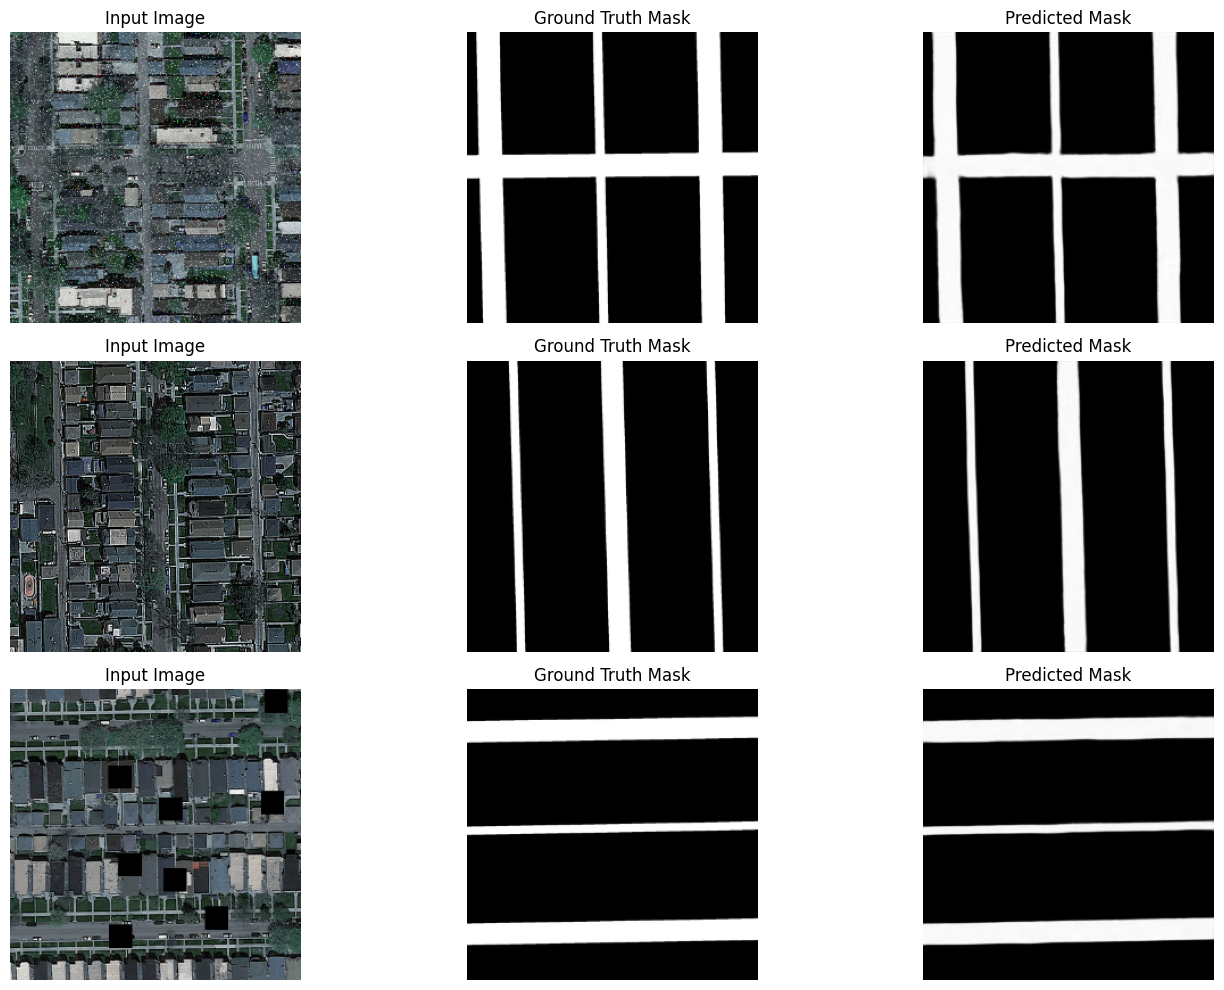

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test set
predictions = model.predict(X_test)

# Function to visualize input, ground truth, and prediction
def visualize_predictions(X, y_true, y_pred, num_samples=3):
    plt.figure(figsize=(15, 10))

    for i in range(num_samples):
        # Input Image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(X[i])  # Show RGB image
        plt.title("Input Image")
        plt.axis('off')

        # Ground Truth Mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(y_true[i].squeeze(), cmap='gray')  # Show grayscale mask
        plt.title("Ground Truth Mask")
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(y_pred[i].squeeze(), cmap='gray')  # Show predicted mask
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize 3 samples
visualize_predictions(X_test, y_test, predictions, num_samples=3)
